In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
gamma = 5.0/3.0
B0 = 1.0
rho0 = 1.0
shear_thickness = 1.0
beta = 2.0
p0 = beta * B0**2 / 2.0
rr = 0.2
br = 1.0
theta = np.pi / 2.0
V0 = Vf = np.sqrt(B0**2 / rho0 + gamma * p0 / rho0)
x_max = 2.0 * np.pi * shear_thickness / 0.4
y_max = 10.0 * shear_thickness
dx = shear_thickness / 32.0
dy = dx
nx = int(x_max / dx)
ny = int(2.0 * y_max / dy)
dt = 0.0
CFL = 0.7
x = np.arange(0.0, x_max - dx, dx)
y = np.arange(-y_max, y_max, dy)
X, Y = np.meshgrid(x, y)

U = np.zeros([8, x.shape[0], y.shape[0]])
rho_init = rho0 / 2.0 * ((1.0 - rr) * np.tanh(Y / shear_thickness) + 1.0 + rr).T
u_init = -V0 / 2.0 * np.tanh(Y / shear_thickness).T
v_init = 0.02 * V0 * (np.cos(2.0 * np.pi * X / x_max) / np.cosh(Y / shear_thickness)**2).T
w_init = 0.0
Bx_init = B0 / 2.0 * ((1.0 - br) * np.tanh(Y / shear_thickness) + 1.0 + br).T * np.cos(theta)
By_init = 0.0
Bz_init = B0 / 2.0 * ((1.0 - br) * np.tanh(Y / shear_thickness) + 1.0 + br).T * np.sin(theta)
p_init = beta * (Bx_init**2 + By_init**2 + Bz_init**2) / 2.0
U[0, :, :] = rho_init
U[1, :, :] = rho_init * u_init
U[2, :, :] = rho_init * v_init
U[3, :, :] = rho_init * w_init
U[4, :, :] = Bx_init
U[5, :, :] = By_init
U[6, :, :] = Bz_init
U[7, :, :] = p_init/(gamma-1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)
G = np.zeros(U.shape)
G_bar = np.zeros(G.shape)

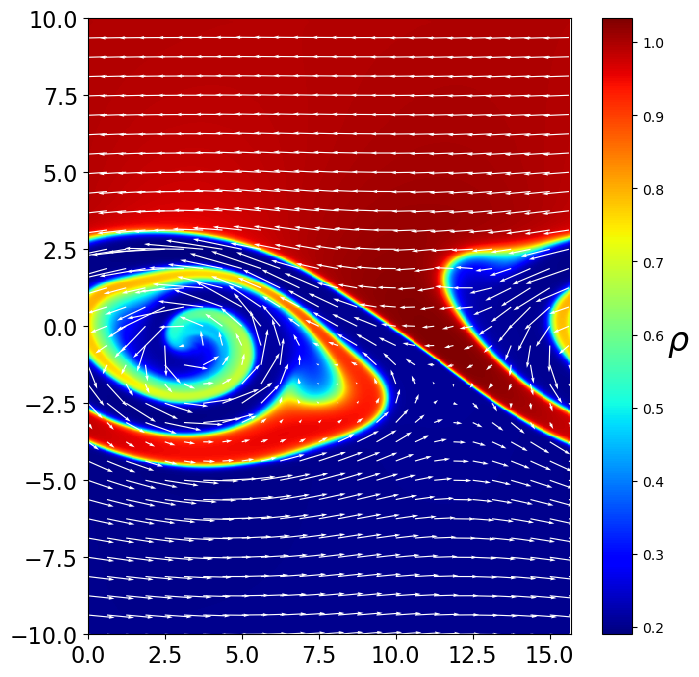

In [15]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

#log = np.loadtxt("log_KH_highreso.txt", delimiter=',')
dirname = "results_highreso"
step = 21000
filename = f"{dirname}/KH_{step}.bin"
with open(filename, 'rb') as f:
    U = np.fromfile(f, dtype=np.float64)
U = U.reshape(nx, ny, 8).T

rho = U[0, :, :]
u = U[1, :, :] / rho 
v = U[2, :, :] / rho 
w = U[3, :, :] / rho 
Bx = U[4, :, :]
By = U[5, :, :]
Bz = U[6, :, :]
e = U[7, :, :]

contour = ax1.pcolormesh(X, Y, rho, cmap='jet')
cbar = plt.colorbar(contour, ax=ax1)
cbar.set_label(r"$\rho$", fontsize=24, rotation=0, labelpad=10)

quiver_interval = 20
ax1.quiver(X[::quiver_interval, ::quiver_interval], Y[::quiver_interval, ::quiver_interval], 
        u[::quiver_interval, ::quiver_interval], v[::quiver_interval, ::quiver_interval],
        scale=15, color='white')

#ax1.text(0.8, 1.02, f"t = {log[int(step/100)][1]:.3f}", transform=ax1.transAxes, fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_xlim(0.0, x_max-dx)
ax1.set_ylim(-y_max, y_max+1e-10)
ax1.set_aspect('equal')

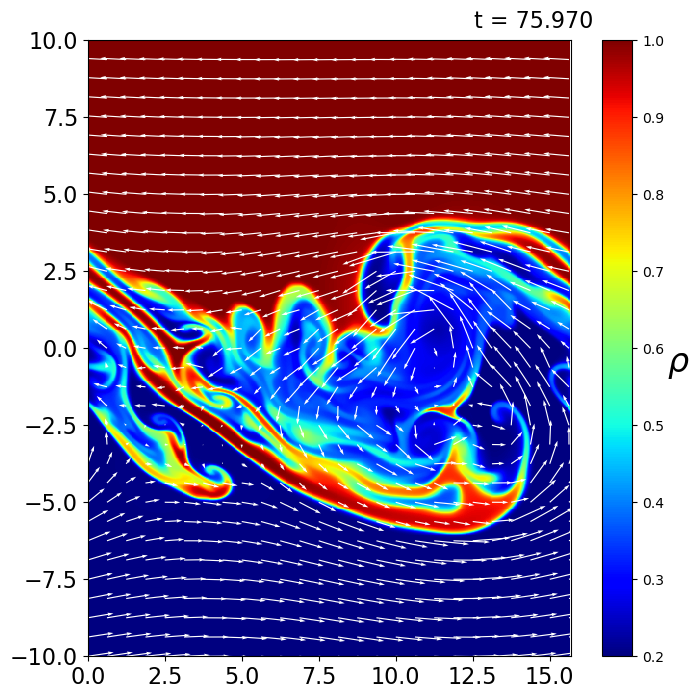

In [16]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

log = np.loadtxt("log_KH_highreso.txt", delimiter=',')
dirname = "results_highreso"
total_steps = int(log[-1][0])
interval = 100
for step in range(0, total_steps+interval, interval):
    ax1.clear()

    filename = f"{dirname}/KH_{step}.bin"
    with open(filename, 'rb') as f:
        U = np.fromfile(f, dtype=np.float64)
    U = U.reshape(nx, ny, 8).T

    rho = U[0, :, :]
    u = U[1, :, :] / rho 
    v = U[2, :, :] / rho 

    contour = ax1.pcolormesh(X, Y, rho, vmin=0.2, vmax=1.0, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax1)
        cbar.set_label(r"$\rho$", fontsize=24, rotation=0, labelpad=10)
    quiver_interval = 20
    ax1.quiver(X[::quiver_interval, ::quiver_interval], Y[::quiver_interval, ::quiver_interval], 
            u[::quiver_interval, ::quiver_interval], v[::quiver_interval, ::quiver_interval],
            scale=15, color='white')

    ax1.text(0.8, 1.02, f"t = {log[int(step/100)][1]:.3f}", transform=ax1.transAxes, fontsize=16)
    ax1.tick_params(labelsize=16)
    ax1.set_xlim(0.0, x_max-dx)
    ax1.set_ylim(-y_max, y_max+1e-10)
    ax1.set_aspect('equal')

    fig.savefig(f"pictures/{step}.png", dpi=200)


filename = "KH_highreso_rho.mp4"
img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 10.0
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, total_steps+interval, interval):
    img = cv2.imread(f'./pictures/{step}.png')
    video.write(img)
video.release()